In [1]:
import numpy as np 
import pandas as pd 
import gc
import os
from lightgbm import LGBMClassifier
import lightgbm as lgbm
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import category_encoders as ce

In [2]:
df = pd.read_csv("train.csv"); test = pd.read_csv("test.csv"); df = pd.concat([df, test]).drop(["TXN_TRM"],1)
df.rename(columns = {"TARGET": "target"}, inplace = True)
df.loc[df.TXN_SOURCE == "R", "TXN_SOURCE"] = "O"
df = df.sort_values(["CST_NR", "DAY_OF_MONTH"])
df["tefo"] = 1
df["transaction_count_by_customer"] = df.groupby("CST_NR")["tefo"].transform("cumsum")
df["transaction_count_by_card"] = df.groupby("CC_NR")["tefo"].transform("cumsum")

C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10188/3267574585.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = pd.read_csv("train.csv"); test = pd.read_csv("test.csv"); df = pd.concat([df, test]).drop(["TXN_TRM"],1)


In [3]:
df["day_diff"] = df.groupby("CST_NR")["DAY_OF_MONTH"].transform("diff").fillna(df.DAY_OF_MONTH)
df["day_diff_std"] = df.groupby("CST_NR")["day_diff"].transform("std").fillna(0)

def calc_count(df, by, on):
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']
    
    return df[by].map(counts)

#df['country_count'] = calc_count(df, by='COUNTRY', on='target')
df['city_target_count'] = calc_count(df, by='CITY', on='target')
df['mc_name_target_count'] = calc_count(df, by='MC_NAME', on='target')
df['mc_id_target_count'] = calc_count(df, by='MC_ID', on='target')
df['mcc_code_target_count'] = calc_count(df, by='MCC_CODE', on='target')

df["total_amount_per_customer"] = df.groupby(["CST_NR"])["TXN_AMNT"].transform("cumsum")
df["money_change"] = df.groupby(["CST_NR"])["total_amount_per_customer"].transform("pct_change")


df["same_day_MCC_CODE_count"] = df.groupby(["CST_NR", "DAY_OF_MONTH"])["MCC_CODE"].transform("nunique")
#df["same_day_MC_NAME_count"] = df.groupby(["CST_NR", "DAY_OF_MONTH"])["MC_NAME"].transform("nunique")
#df["same_day_MC_ID_count"] = df.groupby(["CST_NR", "DAY_OF_MONTH"])["MC_ID"].transform("nunique")
df["same_day_CITY_count"] = df.groupby(["CST_NR", "DAY_OF_MONTH"])["CITY"].transform("nunique")
df["same_day_COUNTRY_count"] = df.groupby(["CST_NR", "DAY_OF_MONTH"])["COUNTRY"].transform("nunique")

df["hours_txn_time"] = df.TXN_TIME.transform(lambda x : str(x)[:2] if len(str(x)) == 6 else str(x)[:1]).astype(int)

df["time"] = (df.DAY_OF_MONTH * 24) + (df.hours_txn_time)
df["time_difference_between_tx"] = df.groupby('CST_NR')['time'].transform("pct_change")

df.money_change.fillna(0, inplace = True)
df.time_difference_between_tx.fillna(0, inplace = True)

df["total_money_spent_std"] = df.groupby(["CST_NR"])["TXN_AMNT"].transform("std")
df["number_of_transactions_done_total"] = df.groupby(["CST_NR"])["tefo"].transform("sum")

test = df.loc[df.target.isnull()]
df = df.loc[df.target.notnull()].drop(["ID"],1)

C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10188/3470698812.py:39: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.loc[df.target.notnull()].drop(["ID"],1)


In [4]:
cols_to_encode = df.select_dtypes(exclude=[np.number]).columns.to_list()

In [5]:
smoothing = 0.15
train_y = df['target']
oof = pd.DataFrame([])
for tr_idx, oof_idx in StratifiedKFold(n_splits=5, random_state=33, shuffle=True).split(df, train_y):
    ce_target_encoder = ce.TargetEncoder(cols = cols_to_encode, smoothing=smoothing).fit(df.iloc[tr_idx,
                                                                                                 :], train_y.iloc[tr_idx])
    oof = oof.append(ce_target_encoder.transform(df.iloc[oof_idx, :]), ignore_index=False)
ce_target_encoder = ce.TargetEncoder(cols = cols_to_encode, smoothing=smoothing).fit(df, train_y)

df = oof.sort_index()
test_transformed = ce_target_encoder.transform(test.drop(["ID"],1))

C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10188/1621178712.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test_transformed = ce_target_encoder.transform(test.drop(["ID"],1))


In [14]:
X = df.drop(["target"],1)
Y = df.target

C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10188/2647171612.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target"],1)


In [135]:
auc = 0
best = 0.9342
for i in df.columns:
    if i in ["target"]:
        continue
    else:
        X = df.drop(["target", i],1)
        Y = df.target
        y = Y
        skf = StratifiedKFold(n_splits=5, random_state = 5451, shuffle = True)
        scores = []
        tr_scores = []
        for train_index, test_index in skf.split(X, y):
            train_df = X.loc[train_index].reset_index(drop = True)
            valid_df = X.loc[test_index].reset_index(drop = True)
            train_y, valid_y = y[train_index], y[test_index]

            model = lgbm.LGBMClassifier(metric = "auc", objective = "binary", random_state = 33)
            model.fit(train_df,train_y)
            predictions = model.predict_proba(valid_df)[:,1]
            scores.append(roc_auc_score(valid_y, predictions))

            train_preds = model.predict_proba(train_df)[:,1]
            tr_scores.append(roc_auc_score(train_y, train_preds))
        print(f"without {i}, valid auc is > {np.mean(scores)}")
        if np.mean(scores) > best:
            print(f"{i} atiliyoooooooooooorrrrrr.")
            df.drop([i], 1, inplace= True)
            best = np.mean(scores)
        else:
            continue

C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without TXN_TIME, valid auc is > 0.9316889166264541


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without TXN_AMNT, valid auc is > 0.9356269332942319
TXN_AMNT atiliyoooooooor.


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:28: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop([i], 1, inplace= True)
C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without transaction_count_by_customer, valid auc is > 0.935579714309181


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without transaction_count_by_card, valid auc is > 0.9330780627136368


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without day_diff, valid auc is > 0.9330260329579035


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without day_diff_std, valid auc is > 0.9342714365029773


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without country_count, valid auc is > 0.93969676074499
country_count atiliyoooooooor.


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:28: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop([i], 1, inplace= True)
C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without city_target_count, valid auc is > 0.939298422575362


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without mc_name_target_count, valid auc is > 0.9355162347464591


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without mc_id_target_count, valid auc is > 0.9379075081089754


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without mcc_code_target_count, valid auc is > 0.9362207183640809


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without total_amount_per_customer, valid auc is > 0.9301375559036293


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without money_change, valid auc is > 0.9358105590775191


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without same_day_MCC_CODE_count, valid auc is > 0.9370060690532955


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without same_day_city_count, valid auc is > 0.9351347156423901


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without same_day_countries_count, valid auc is > 0.9328241172946529


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without hours_txn_time, valid auc is > 0.9341794746144856


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without time, valid auc is > 0.9311513450721215


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without time_difference_between_tx, valid auc is > 0.9355243945355689


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without customers_last_transaction, valid auc is > 0.9408321661822183
customers_last_transaction atiliyoooooooor.


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:28: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop([i], 1, inplace= True)
C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without CST_NR, valid auc is > 0.9430039356554847
CST_NR atiliyoooooooor.


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:28: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop([i], 1, inplace= True)
C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without CC_NR, valid auc is > 0.9243442369024393


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without TXN_ENTRY, valid auc is > 0.9387608405665532


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without TXN_SOURCE, valid auc is > 0.9352614517446435


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without CITY, valid auc is > 0.9423045403659198


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without COUNTRY, valid auc is > 0.9346126210859194


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without MC_NAME, valid auc is > 0.9264446508765337


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without MC_ID, valid auc is > 0.9373127651237716


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10976/2128457751.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target", i],1)


without MCC_CODE, valid auc is > 0.9386906735398197


In [48]:
X = df.drop(["target"],1)
Y = df.target
y = Y

C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_9380/3680766252.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target"],1)


In [49]:
skf = StratifiedKFold(n_splits=5, random_state = 545, shuffle = True)
scores = []
tr_scores = []
for train_index, test_index in skf.split(X, y):
    X  = df.drop(["target"], 1).reset_index(drop=True)
    y = df.target.reset_index(drop=True)
    train_df = X.loc[train_index].reset_index(drop = True)
    valid_df = X.loc[test_index].reset_index(drop = True)
    train_y, valid_y = y[train_index], y[test_index]

    model = lgbm.LGBMClassifier(**{'reg_alpha': 7.714425597409395,
 'reg_lambda': 5.663580655710298,
 'num_leaves': 5,
 'min_child_samples': 81,
 'max_depth': 19,
 'colsample_bytree': 0.15871987715954747,
 'cat_smooth': 16,
 'learning_rate': 0.005,
 'metric': 'auc',
 'objective': 'binary',
 'cat_l2': 7,
 'min_data_per_group': 116})
    model.fit(train_df,train_y)
    predictions = model.predict_proba(valid_df)[:,1]
    scores.append(roc_auc_score(valid_y, predictions))

    train_preds = model.predict_proba(train_df)[:,1]
    tr_scores.append(roc_auc_score(train_y, train_preds))
print(f"valid auc is > {np.mean(scores)}")


C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_9380/3691664042.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X  = df.drop(["target"], 1).reset_index(drop=True)
C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_9380/3691664042.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X  = df.drop(["target"], 1).reset_index(drop=True)
C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_9380/3691664042.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X  = df.drop(["target"], 1).reset_index(drop=True)
C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_9380/3691664042.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X  = df.drop(["target"], 1).reset_index

valid auc is > 0.9677577023163091


In [50]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.15 with hours txn time included as an integer plus dropping mc_id_count and mc_name_count
#plus adding 2 additional features 

Train AUC score: 0.9684 Valid AUC score: 0.9678, STD: 0.0023


In [72]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.15 with hours txn time included as an integer plus dropping mc_id_count and mc_name_count
#plus adding 2 additional features 

Train AUC score: 0.9909 Valid AUC score: 0.9886, STD: 0.0018


In [64]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.15 with hours txn time included as an integer plus dropping mc_id_count and mc_name_count
#plus adding 2 additional features 

Train AUC score: 0.9853 Valid AUC score: 0.9841, STD: 0.0023


In [86]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.15 with hours txn time included as an integer plus dropping mc_id_count and mc_name_count

Train AUC score: 0.9686 Valid AUC score: 0.9342, STD: 0.0056


In [76]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.1 with hours txn time included as an integer plus dropping mc_id_count and mc_name_count

Train AUC score: 0.9712 Valid AUC score: 0.9359, STD: 0.0076


In [66]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.08 with hours txn time included as an integer plus dropping mc_id_count and mc_name_count

Train AUC score: 0.9735 Valid AUC score: 0.9438, STD: 0.0075


In [45]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.09 with hours txn time included as an integer

Train AUC score: 0.9705 Valid AUC score: 0.9355, STD: 0.0058


In [35]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.08 with hours txn time included as an integer

Train AUC score: 0.9754 Valid AUC score: 0.9431, STD: 0.0082


In [25]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.08 with hours txn time included

Train AUC score: 0.9726 Valid AUC score: 0.9369, STD: 0.0108


In [13]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.09

Train AUC score: 0.9738 Valid AUC score: 0.9414, STD: 0.0125


In [181]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.09

Train AUC score: 0.9682 Valid AUC score: 0.9436, STD: 0.0110


In [133]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.09

Train AUC score: 0.9694 Valid AUC score: 0.9383, STD: 0.0094


In [121]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.11

Train AUC score: 0.9717 Valid AUC score: 0.9342, STD: 0.0068


In [109]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))  #0.15

Train AUC score: 0.9700 Valid AUC score: 0.9323, STD: 0.0096


In [87]:
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
)) #0.1

Train AUC score: 0.9694 Valid AUC score: 0.9383, STD: 0.0094


In [52]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import lightgbm as lgbm

In [53]:
# Train and score baseline model
baseline = lgbm.LGBMClassifier(objective = "binary", boosting_type = "gbdt", metric = "auc", is_unbalance = True,
                               learning_rate = 0.005,
                               random_state=0)
baseline_score = cross_val_score(
    baseline, X, y, cv=5, scoring="roc_auc")

baseline_score = baseline_score.mean()

print(f"Roc auc Score: {baseline_score:.4}")

Roc auc Score: 0.9838


In [ ]:
X = df.drop(["target"],1)

  0%|          | 0/27 [00:00<?, ?it/s]

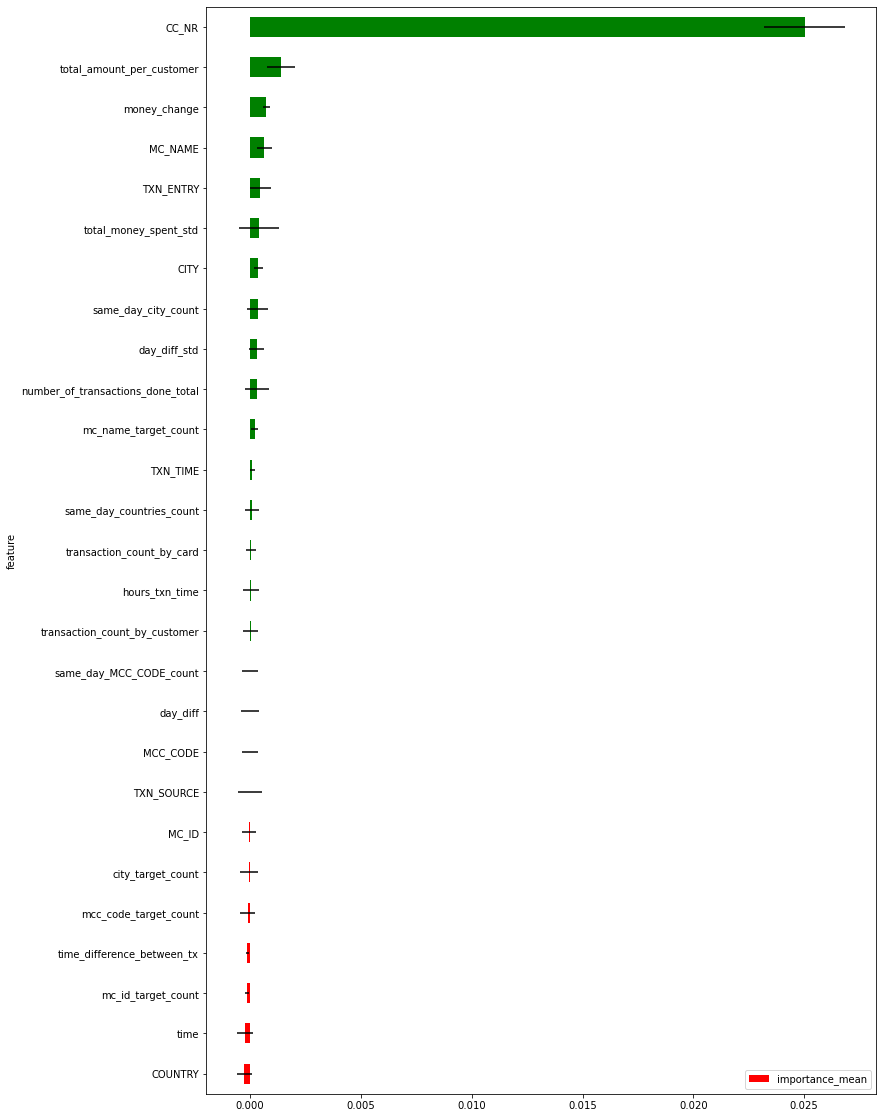

In [54]:
import pandas as pd
from sklearn.model_selection import KFold
from lofo import LOFOImportance, Dataset, plot_importance
%matplotlib inline

# extract a sample of the data
sample_df = df.sample(frac=1, random_state=0)


# define the validation scheme
cv = StratifiedKFold(n_splits=4, shuffle=False)
target = "target"
# define the binary target and the features
dataset = Dataset(df=sample_df, target="target", features=[col for col in X.columns if col != target])

# define the validation scheme and scorer. The default model is LightGBM
lofo_imp = LOFOImportance(dataset, cv=cv, scoring="roc_auc")

# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()

# plot the means and standard deviations of the importances
plot_importance(importance_df, figsize=(12, 20))

In [15]:
df.drop(["time"], 1, inplace = True)
test.drop(["time"], 1, inplace = True)

C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10188/1638491600.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(["time"], 1, inplace = True)
C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10188/1638491600.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test.drop(["time"], 1, inplace = True)


In [22]:
X = df.drop(["target"],1)
y = df.target

C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10188/3191008212.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target"],1)


In [23]:
def create(hyperparams):
    model = LGBMClassifier(**hyperparams)
    return model

def fit(model, X, y):
    model.fit(X, y)
    return model

def fit_with_stop(model, X, y, X_val, y_val, esr):
    model.fit(X, y,
              eval_set=(X_val, y_val),
              early_stopping_rounds=esr, 
              verbose=200)
    return model

def evaluate(model, X, y):
    yp = model.predict_proba(X)[:, 1]
    auc_score = roc_auc_score(y, yp)
    return auc_score

def kfold_evaluation(X, y, k, hyperparams, esr=300):
    scores = []
    
    print(f"\n------ {k}-fold evaluation -----")
    print(hyperparams)
    
    kf = StratifiedKFold(k)
    for i, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        print(f"\n----- FOLD {i} -----")
        
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[test_idx]
        y_val = y.iloc[test_idx]
        
        model = create(hyperparams)
        model = fit_with_stop(model, X_train, y_train, X_val, y_val, esr)
        train_score = evaluate(model, X_train, y_train)
        val_score = evaluate(model, X_val, y_val)
        scores.append((train_score, val_score))
        
        print(f"Fold {i} | Eval AUC: {val_score}")
        
        
    scores = pd.DataFrame(scores, columns=['train score', 'validation score'])
    
    return scores

def kfold_prediction(X, y, X_test, k, hyperparams, esr=300):
    yp = np.zeros(len(X_test))
    
    print(f"\n------ {k}-fold evaluation -----")
    print(hyperparams)
    
    kf = StratifiedKFold(k)
    for i, (train_idx, test_idx) in enumerate(kf.split(X,y)):
        print(f"\n----- FOLD {i} -----")
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[test_idx]
        y_val = y.iloc[test_idx]
        
        model = create(hyperparams)
        model = fit_with_stop(model, X_train, y_train, X_val, y_val, esr)
        yp += model.predict_proba(X_test)[:, 1] / k
    
    return yp

In [24]:
K = 5
BEST_PARAMS = {'n_estimators': 10000, 'learning_rate': 0.05,
 'metric': 'auc'
}

In [25]:
def objective(trial):
    hyperparams = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 5, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 64),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
        'cat_smooth' : trial.suggest_int('cat_smooth', 10, 100),
        'cat_l2': trial.suggest_int('cat_l2', 1, 20),
        'min_data_per_group': trial.suggest_int('min_data_per_group', 50, 200),
        "is_unbalance" : True,
        "verbose" :2
    }
    
    hyperparams.update(BEST_PARAMS)
    
    scores = kfold_evaluation(X, y, K, hyperparams, 300)
    
    return scores['validation score'].mean()

In [27]:
X = df.drop(["target"],1)
y = df.target

C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_10188/3191008212.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop(["target"],1)


In [28]:
import gc
gc.collect()

0

In [ ]:
# Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout= 3600*0.75, n_jobs = -1)

[I 2021-11-29 19:21:16,985] A new study created in memory with name: no-name-e925d3f4-c494-4caf-aacc-a1f10cf7095b
C:\Users\analyticahouse\Anaconda3\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(



------ 5-fold evaluation -----
{'reg_alpha': 7.775306033503444, 'reg_lambda': 9.463453358243301, 'num_leaves': 700, 'min_child_samples': 52, 'max_depth': 16, 'colsample_bytree': 0.36192394322679533, 'cat_smooth': 20, 'cat_l2': 5, 'min_data_per_group': 154, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

------ 5-fold evaluation -----
{'reg_alpha': 2.14647633345709, 'reg_lambda': 4.317595000944313, 'num_leaves': 819, 'min_child_samples': 93, 'max_depth': 19, 'colsample_bytree': 0.3779831292639084, 'cat_smooth': 26, 'cat_l2': 13, 'min_data_per_group': 200, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

------ 5-fold evaluation -----
{'reg_alpha': 1.3429997011960169, 'reg_lambda': 3.4293591512416546, 'num_leaves': 116, 'min_child_samples': 82, 'max_depth': 49, 'colsample_bytree': 0.26557876636837535, 'cat_smooth': 90, 'cat_l2': 9, 'min_data_per_group': 183, 'is_unbalance': True, 'verb

C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'earl

[200]	valid_0's auc: 0.966801
[200]	valid_0's auc: 0.975034
[200]	valid_0's auc: 0.953115
[400]	valid_0's auc: 0.972853
[200]	valid_0's auc: 0.974874
[200]	valid_0's auc: 0.975248
[400]	valid_0's auc: 0.975921
[400]	valid_0's auc: 0.961407
[200]	valid_0's auc: 0.968847
[200]	valid_0's auc: 0.95821
[600]	valid_0's auc: 0.97444
[200]	valid_0's auc: 0.972268
[600]	valid_0's auc: 0.963027
[400]	valid_0's auc: 0.976276
[600]	valid_0's auc: 0.975251
[400]	valid_0's auc: 0.976509
Fold 0 | Eval AUC: 0.976011817104722

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.975381
[800]	valid_0's auc: 0.964079
[400]	valid_0's auc: 0.962224
[600]	valid_0's auc: 0.976751
[1000]	valid_0's auc: 0.964539
[1200]	valid_0's auc: 0.964676
[600]	valid_0's auc: 0.97679
[1400]	valid_0's auc: 0.964679
[400]	valid_0's auc: 0.970409
Fold 0 | Eval AUC: 0.9646785422378557

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.975645
[600]	valid_0's auc: 0.963051
[800]	valid_0's auc: 0.976886
[400]	valid_0's auc: 0.974049
[800]	valid_0's auc: 0.976726
Fold 0 | Eval AUC: 0.9768578745005383

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.959879
[800]	valid_0's auc: 0.963345
[1000]	valid_0's auc: 0.97704
[1200]	valid_0's auc: 0.976018
[1000]	valid_0's auc: 0.963377
[1200]	valid_0's auc: 0.963377
[600]	valid_0's auc: 0.970798
Fold 0 | Eval AUC: 0.9634114601418089

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1200]	valid_0's auc: 0.977137
[200]	valid_0's auc: 0.937881
[600]	valid_0's auc: 0.974565
[400]	valid_0's auc: 0.961468
Fold 0 | Eval AUC: 0.9771796384841102

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1400]	valid_0's auc: 0.976136
[800]	valid_0's auc: 0.970834
[1600]	valid_0's auc: 0.976136
Fold 0 | Eval AUC: 0.9709103665410959

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.961151
[800]	valid_0's auc: 0.974722
[200]	valid_0's auc: 0.949318
[400]	valid_0's auc: 0.94472
Fold 0 | Eval AUC: 0.9761748221435527

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9615703087704065

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.974715
[600]	valid_0's auc: 0.946343
[200]	valid_0's auc: 0.945632
[200]	valid_0's auc: 0.950774
[400]	valid_0's auc: 0.953878
Fold 0 | Eval AUC: 0.9747949870692547

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.947224
[200]	valid_0's auc: 0.967698
[200]	valid_0's auc: 0.927938
[1000]	valid_0's auc: 0.947408
[600]	valid_0's auc: 0.954867
[400]	valid_0's auc: 0.955096
[1200]	valid_0's auc: 0.947643
[400]	valid_0's auc: 0.9514
[1400]	valid_0's auc: 0.947653
[1600]	valid_0's auc: 0.947653
[200]	valid_0's auc: 0.951462
Fold 1 | Eval AUC: 0.9476529086604314

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.954936
[400]	valid_0's auc: 0.968043
[600]	valid_0's auc: 0.952997
[400]	valid_0's auc: 0.923733
[600]	valid_0's auc: 0.955781
[1000]	valid_0's auc: 0.955024
Fold 2 | Eval AUC: 0.929111941987508

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.953351
[1200]	valid_0's auc: 0.955024
Fold 1 | Eval AUC: 0.9551917759639063

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.953354
Fold 1 | Eval AUC: 0.9682431051567026

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 | Eval AUC: 0.9533833102575976

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.956452
[200]	valid_0's auc: 0.940933
[200]	valid_0's auc: 0.951724
[400]	valid_0's auc: 0.95587
[1000]	valid_0's auc: 0.95727
[200]	valid_0's auc: 0.945806
[400]	valid_0's auc: 0.948253
[600]	valid_0's auc: 0.957403
[1200]	valid_0's auc: 0.957756
[200]	valid_0's auc: 0.978638
[400]	valid_0's auc: 0.951904
[400]	valid_0's auc: 0.956898
[600]	valid_0's auc: 0.949685
[800]	valid_0's auc: 0.957953
[200]	valid_0's auc: 0.905213
[1400]	valid_0's auc: 0.958041
[200]	valid_0's auc: 0.92508
[800]	valid_0's auc: 0.950486
[1000]	valid_0's auc: 0.958339
[600]	valid_0's auc: 0.952918
[1600]	valid_0's auc: 0.958127
[400]	valid_0's auc: 0.979774
[1000]	valid_0's auc: 0.950503
[400]	valid_0's auc: 0.913364
[600]	valid_0's auc: 0.958261
[1200]	valid_0's auc: 0.958393
[1200]	valid_0's auc: 0.950726
[1800]	valid_0's auc: 0.958243
[1400]	valid_0's auc: 0.950743
Fold 2 | Eval AUC: 0.9507430003271212

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1400]	valid_0's auc: 0.958483
[800]	valid_0's auc: 0.953403
[1600]	valid_0's auc: 0.958474
[400]	valid_0's auc: 0.925876
[2000]	valid_0's auc: 0.958254
Fold 1 | Eval AUC: 0.9584791919563899

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.979949
[600]	valid_0's auc: 0.916038
[2200]	valid_0's auc: 0.958248
Fold 1 | Eval AUC: 0.9582751942521905

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[800]	valid_0's auc: 0.958785
[1000]	valid_0's auc: 0.953814
[800]	valid_0's auc: 0.917037
Fold 2 | Eval AUC: 0.9801257200998587

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1200]	valid_0's auc: 0.953824
Fold 3 | Eval AUC: 0.9540214251033439

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.927627
[1000]	valid_0's auc: 0.917549
[1200]	valid_0's auc: 0.917549
Fold 2 | Eval AUC: 0.9175467854091507

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.959005
[200]	valid_0's auc: 0.935154
[200]	valid_0's auc: 0.963208
[800]	valid_0's auc: 0.928098
[1200]	valid_0's auc: 0.959092
[1000]	valid_0's auc: 0.928544
[400]	valid_0's auc: 0.967728
[1400]	valid_0's auc: 0.959225
[200]	valid_0's auc: 0.978306
[400]	valid_0's auc: 0.94182
[1200]	valid_0's auc: 0.928991
[1600]	valid_0's auc: 0.959254
[1400]	valid_0's auc: 0.928926
[1800]	valid_0's auc: 0.959257
Fold 2 | Eval AUC: 0.9291359568903723

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.976664
Fold 1 | Eval AUC: 0.9592814391851521

----- FOLD 2 -----
[200]	valid_0's auc: 0.921979


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[600]	valid_0's auc: 0.943395
[600]	valid_0's auc: 0.968574
[400]	valid_0's auc: 0.980147
[800]	valid_0's auc: 0.94532
[200]	valid_0's auc: 0.944711
[800]	valid_0's auc: 0.96896
[400]	valid_0's auc: 0.97679
[1000]	valid_0's auc: 0.946133
[1200]	valid_0's auc: 0.946803
[600]	valid_0's auc: 0.979903
[1400]	valid_0's auc: 0.94684
[400]	valid_0's auc: 0.923736
[1600]	valid_0's auc: 0.946839
Fold 3 | Eval AUC: 0.9468392938166084

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 | Eval AUC: 0.9770360760573947

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-11-29 19:44:54,397] Trial 4 finished with value: 0.9601866056493087 and parameters: {'reg_alpha': 7.963812487912805, 'reg_lambda': 5.972050874333408, 'num_leaves': 929, 'min_child_samples': 91, 'max_depth': 11, 'colsample_bytree': 0.46413831883652845, 'cat_smooth': 42, 

Fold 4 | Eval AUC: 0.9802175352805638

------ 5-fold evaluation -----
{'reg_alpha': 6.768124926335319, 'reg_lambda': 6.167002911527738, 'num_leaves': 239, 'min_child_samples': 82, 'max_depth': 60, 'colsample_bytree': 0.20324257072828514, 'cat_smooth': 74, 'cat_l2': 15, 'min_data_per_group': 193, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.969261
[400]	valid_0's auc: 0.950746
[200]	valid_0's auc: 0.94979
[600]	valid_0's auc: 0.926009
[1200]	valid_0's auc: 0.969531
[600]	valid_0's auc: 0.953282
[200]	valid_0's auc: 0.955713
[200]	valid_0's auc: 0.923635
[200]	valid_0's auc: 0.961355
[800]	valid_0's auc: 0.954302
[800]	valid_0's auc: 0.92736
[1400]	valid_0's auc: 0.969838
[200]	valid_0's auc: 0.982964
[400]	valid_0's auc: 0.95595
[1000]	valid_0's auc: 0.954809
[1200]	valid_0's auc: 0.954863
Fold 3 | Eval AUC: 0.9548981135890968

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.928012
[400]	valid_0's auc: 0.966811
[1600]	valid_0's auc: 0.969734
[400]	valid_0's auc: 0.96911
Fold 2 | Eval AUC: 0.9699004839885876

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1200]	valid_0's auc: 0.92893
[600]	valid_0's auc: 0.957976
[600]	valid_0's auc: 0.968784
[400]	valid_0's auc: 0.982734
[1400]	valid_0's auc: 0.92984
[400]	valid_0's auc: 0.925675
[800]	valid_0's auc: 0.95944
[1600]	valid_0's auc: 0.930128
[600]	valid_0's auc: 0.970975
[800]	valid_0's auc: 0.969285
[1800]	valid_0's auc: 0.930138
[200]	valid_0's auc: 0.939568
[2000]	valid_0's auc: 0.930138


[I 2021-11-29 19:48:44,297] Trial 5 finished with value: 0.9771754678132869 and parameters: {'reg_alpha': 6.631260077505554, 'reg_lambda': 7.241052182560413, 'num_leaves': 463, 'min_child_samples': 16, 'max_depth': 50, 'colsample_bytree': 0.1282079690439505, 'cat_smooth': 54, 'cat_l2': 5, 'min_data_per_group': 87}. Best is trial 5 with value: 0.9771754678132869.


Fold 4 | Eval AUC: 0.9832927992683689

------ 5-fold evaluation -----
{'reg_alpha': 9.650019109009078, 'reg_lambda': 8.247761503909386, 'num_leaves': 76, 'min_child_samples': 82, 'max_depth': 20, 'colsample_bytree': 0.45502098103992694, 'cat_smooth': 29, 'cat_l2': 16, 'min_data_per_group': 84, 'is_unbalance': True, 'verbose': 2, 'n_estimators': 10000, 'learning_rate': 0.05, 'metric': 'auc'}

----- FOLD 0 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[2200]	valid_0's auc: 0.930138
Fold 2 | Eval AUC: 0.9301377440859251

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's auc: 0.969409
[1000]	valid_0's auc: 0.960319
[800]	valid_0's auc: 0.971758
[1200]	valid_0's auc: 0.969684
[1400]	valid_0's auc: 0.969672
[200]	valid_0's auc: 0.978248
[1600]	valid_0's auc: 0.969717
[1200]	valid_0's auc: 0.960829
[200]	valid_0's auc: 0.959753
[400]	valid_0's auc: 0.950353
[1800]	valid_0's auc: 0.969718


In [70]:
BEST_PARAMS = {'reg_alpha': 7.714425597409395, 
               'reg_lambda': 5.663580655710298, 'num_leaves': 5, 'min_child_samples': 81, 'max_depth': 19,
               'colsample_bytree': 0.15871987715954747, 'cat_smooth': 16,
               "n_estimators": 10000,
               "learning_rate": 0.005,
               "metric": "auc",
               "objective": "binary",
               'cat_l2': 7, 'min_data_per_group': 116}
#0.9869

In [78]:
BEST_PARAMS.update(study.best_params)
BEST_PARAMS.update({"learning_rate" : 0.005})

In [64]:
BEST_PARAMS = {'reg_alpha': 3.5790836474960503, 'reg_lambda': 6.413343394503462, 'num_leaves': 15, 'n_estimators': 10000,
               "metric" : "auc",
               "objective": "binary",
               "learning_rate" : 0.005,
               'min_child_samples': 61, 'max_depth': 21, 'colsample_bytree': 0.12185204941673947, 
               'cat_smooth': 58, 'cat_l2': 15, 'min_data_per_group': 154}

In [14]:
BEST_PARAMS = {'reg_alpha': 4.666805786199625, 'reg_lambda': 9.928178820417113, 'num_leaves': 552, 
               'min_child_samples': 49, 'max_depth': 20, 'n_estimators': 10000,
 'learning_rate': 0.005,
 'metric': 'auc',
               'colsample_bytree': 0.2940671359326277, 'cat_smooth': 58, 'cat_l2': 4, 'min_data_per_group': 81}

In [25]:
BEST_PARAMS.update(study.best_params)
BEST_PARAMS

{'n_estimators': 10000,
 'learning_rate': 0.05,
 'metric': 'auc',
 'reg_alpha': 9.250545911496724,
 'reg_lambda': 7.721831841556209,
 'num_leaves': 5,
 'min_child_samples': 12,
 'max_depth': 50,
 'colsample_bytree': 0.4395938386171192,
 'cat_smooth': 34,
 'cat_l2': 19,
 'min_data_per_group': 110}

In [26]:
BEST_PARAMS = {'n_estimators': 10000,
 'learning_rate': 0.005,
 'metric': 'auc',
 'reg_alpha': 9.250545911496724,
 'reg_lambda': 7.721831841556209,
 'num_leaves': 5,
 'min_child_samples': 12,
 'max_depth': 50,
 'colsample_bytree': 0.4395938386171192,
 'cat_smooth': 34,
 'cat_l2': 19,
 'min_data_per_group': 110}

In [86]:
test["target"] = kfold_prediction(X, Y, test.drop(["target"],1), 5, BEST_PARAMS, 500)
#test["target"] = kfold_prediction(X, Y, test.drop(["target"],1), 5, BEST_PARAMS, 1000)

C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_7580/1857205077.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test["target"] = kfold_prediction(X, Y, test.drop(["target"],1), 5, BEST_PARAMS, 500)
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of Li


------ 5-fold evaluation -----
{'n_estimators': 10000, 'learning_rate': 0.005, 'metric': 'auc', 'reg_alpha': 7.1828967429274435, 'reg_lambda': 6.8978587137938, 'num_leaves': 665, 'min_child_samples': 39, 'max_depth': 6, 'colsample_bytree': 0.42817622930503163, 'cat_smooth': 92, 'cat_l2': 17, 'min_data_per_group': 189}

----- FOLD 0 -----
[200]	valid_0's auc: 0.984053
[400]	valid_0's auc: 0.985243
[600]	valid_0's auc: 0.985985
[800]	valid_0's auc: 0.986288
[1000]	valid_0's auc: 0.986384
[1200]	valid_0's auc: 0.986416
[1400]	valid_0's auc: 0.986416
[1600]	valid_0's auc: 0.986437
[1800]	valid_0's auc: 0.986447
[2000]	valid_0's auc: 0.986489
[2200]	valid_0's auc: 0.986528
[2400]	valid_0's auc: 0.986529
[2600]	valid_0's auc: 0.986558
[2800]	valid_0's auc: 0.986588
[3000]	valid_0's auc: 0.986589
[3200]	valid_0's auc: 0.986574

----- FOLD 1 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.979769
[400]	valid_0's auc: 0.981416
[600]	valid_0's auc: 0.982902
[800]	valid_0's auc: 0.984226
[1000]	valid_0's auc: 0.985046
[1200]	valid_0's auc: 0.985603
[1400]	valid_0's auc: 0.986006
[1600]	valid_0's auc: 0.9863
[1800]	valid_0's auc: 0.986562
[2000]	valid_0's auc: 0.98668
[2200]	valid_0's auc: 0.986678
[2400]	valid_0's auc: 0.986685
[2600]	valid_0's auc: 0.986659
[2800]	valid_0's auc: 0.986577

----- FOLD 2 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.979803
[400]	valid_0's auc: 0.981147
[600]	valid_0's auc: 0.982609
[800]	valid_0's auc: 0.983781
[1000]	valid_0's auc: 0.984532
[1200]	valid_0's auc: 0.985
[1400]	valid_0's auc: 0.985202
[1600]	valid_0's auc: 0.985363
[1800]	valid_0's auc: 0.985473
[2000]	valid_0's auc: 0.985565
[2200]	valid_0's auc: 0.985611
[2400]	valid_0's auc: 0.985708
[2600]	valid_0's auc: 0.985774
[2800]	valid_0's auc: 0.985791
[3000]	valid_0's auc: 0.985817
[3200]	valid_0's auc: 0.985794
[3400]	valid_0's auc: 0.985777

----- FOLD 3 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.983845
[400]	valid_0's auc: 0.984777
[600]	valid_0's auc: 0.985788
[800]	valid_0's auc: 0.9869
[1000]	valid_0's auc: 0.987798
[1200]	valid_0's auc: 0.988359
[1400]	valid_0's auc: 0.988758
[1600]	valid_0's auc: 0.989082
[1800]	valid_0's auc: 0.989379
[2000]	valid_0's auc: 0.989578
[2200]	valid_0's auc: 0.989729
[2400]	valid_0's auc: 0.989842
[2600]	valid_0's auc: 0.989892
[2800]	valid_0's auc: 0.989942
[3000]	valid_0's auc: 0.989982
[3200]	valid_0's auc: 0.990001
[3400]	valid_0's auc: 0.990023
[3600]	valid_0's auc: 0.990014
[3800]	valid_0's auc: 0.989974

----- FOLD 4 -----


C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\analyticahouse\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	valid_0's auc: 0.984316
[400]	valid_0's auc: 0.985427
[600]	valid_0's auc: 0.986711
[800]	valid_0's auc: 0.988204
[1000]	valid_0's auc: 0.989038
[1200]	valid_0's auc: 0.989474
[1400]	valid_0's auc: 0.989739
[1600]	valid_0's auc: 0.989916
[1800]	valid_0's auc: 0.990106
[2000]	valid_0's auc: 0.990211
[2200]	valid_0's auc: 0.990332
[2400]	valid_0's auc: 0.990461
[2600]	valid_0's auc: 0.990552
[2800]	valid_0's auc: 0.99063
[3000]	valid_0's auc: 0.990682
[3200]	valid_0's auc: 0.990697
[3400]	valid_0's auc: 0.990704
[3600]	valid_0's auc: 0.990723
[3800]	valid_0's auc: 0.990734
[4000]	valid_0's auc: 0.990705
[4200]	valid_0's auc: 0.990678


In [88]:
test.to_csv("lasttt.csv", index = False)

In [75]:
test = test[["ID", "target"]].sort_values("ID")
submission_file = pd.read_csv("sample_submission.csv")
test.rename(columns = {"ID": "Id"}, inplace = True)
subm = pd.merge(submission_file, test, on = "Id")
subm.drop(["Predicted"], 1, inplace = True)
subm.rename(columns = {"target": "Predicted"}, inplace = True)

C:\Users\analyticahouse\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\analyticahouse\Anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\ANALYT~1\AppData\Local\Temp/ipykernel_12532/1728463734.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  subm.drop(["Predicted"], 1, inplace = True)


In [81]:
subm.to_csv("encoding2_excluding_smt9869.csv", index = False)

In [84]:
subm.loc[subm.Predicted > 0.90]

,Id,Predicted
16188,16188,0.921887
34630,34630,0.930932
34631,34631,0.948788
34634,34634,0.957301
34635,34635,0.903029
...,...,...
308067,308067,0.968678
308068,308068,0.975047
308069,308069,0.968469
322837,322837,0.948950


In [105]:
frauds = test.loc[test.Predicted > 0.90].Id.tolist()
test.loc[test.Id.isin(frauds), "target"] = 1

In [93]:
cg.loc[cg.CST_NR ==cg.loc[cg.ID == 34630].CST_NR.values[0]]

,TARGET,CST_NR,CC_NR,DAY_OF_MONTH,DAY_OF_WEEK,TXN_TIME,TXN_SOURCE,TXN_TRM,TXN_ENTRY,TXN_AMNT,CITY,COUNTRY,MC_NAME,MC_ID,MCC_CODE,ID
63070,1.0,6a4658dba9e82a6b659acb8ba440dd3a15daff6ffdd4c4...,8fe251b3388e2fbc5a2d40587a4a5fdb20e490ab88852b...,20.0,2.0,1449.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,110.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,3b77c32ebcb3c24a6947c85e057674ac75b65bd24f90b6...,b3b70340fb09803c3fa2f25d0ddc0befaf5ee38e60f684...,9bcde6cbc9021358668bc16cd3fbf6715669db89fd4570...,NaN
63071,1.0,6a4658dba9e82a6b659acb8ba440dd3a15daff6ffdd4c4...,8fe251b3388e2fbc5a2d40587a4a5fdb20e490ab88852b...,9.0,5.0,1021.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,110.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,3b77c32ebcb3c24a6947c85e057674ac75b65bd24f90b6...,b3b70340fb09803c3fa2f25d0ddc0befaf5ee38e60f684...,9bcde6cbc9021358668bc16cd3fbf6715669db89fd4570...,NaN
63072,1.0,6a4658dba9e82a6b659acb8ba440dd3a15daff6ffdd4c4...,8fe251b3388e2fbc5a2d40587a4a5fdb20e490ab88852b...,9.0,5.0,1414.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,110.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,3b77c32ebcb3c24a6947c85e057674ac75b65bd24f90b6...,b3b70340fb09803c3fa2f25d0ddc0befaf5ee38e60f684...,9bcde6cbc9021358668bc16cd3fbf6715669db89fd4570...,NaN
63073,1.0,6a4658dba9e82a6b659acb8ba440dd3a15daff6ffdd4c4...,8fe251b3388e2fbc5a2d40587a4a5fdb20e490ab88852b...,1.0,4.0,1445.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,110.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,3b77c32ebcb3c24a6947c85e057674ac75b65bd24f90b6...,b3b70340fb09803c3fa2f25d0ddc0befaf5ee38e60f684...,9bcde6cbc9021358668bc16cd3fbf6715669db89fd4570...,NaN
63074,1.0,6a4658dba9e82a6b659acb8ba440dd3a15daff6ffdd4c4...,8fe251b3388e2fbc5a2d40587a4a5fdb20e490ab88852b...,9.0,5.0,2348.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,110.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,3b77c32ebcb3c24a6947c85e057674ac75b65bd24f90b6...,b3b70340fb09803c3fa2f25d0ddc0befaf5ee38e60f684...,9bcde6cbc9021358668bc16cd3fbf6715669db89fd4570...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34666,NaN,6a4658dba9e82a6b659acb8ba440dd3a15daff6ffdd4c4...,8fe251b3388e2fbc5a2d40587a4a5fdb20e490ab88852b...,30.0,5.0,1413.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,110.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,3b77c32ebcb3c24a6947c85e057674ac75b65bd24f90b6...,b3b70340fb09803c3fa2f25d0ddc0befaf5ee38e60f684...,9bcde6cbc9021358668bc16cd3fbf6715669db89fd4570...,34666.0
34667,NaN,6a4658dba9e82a6b659acb8ba440dd3a15daff6ffdd4c4...,8fe251b3388e2fbc5a2d40587a4a5fdb20e490ab88852b...,30.0,5.0,2347.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,110.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,3b77c32ebcb3c24a6947c85e057674ac75b65bd24f90b6...,b3b70340fb09803c3fa2f25d0ddc0befaf5ee38e60f684...,9bcde6cbc9021358668bc16cd3fbf6715669db89fd4570...,34667.0
34668,NaN,6a4658dba9e82a6b659acb8ba440dd3a15daff6ffdd4c4...,8fe251b3388e2fbc5a2d40587a4a5fdb20e490ab88852b...,29.0,4.0,1016.0,O,4a1917677530762f21c3c64208a948e9ed007e3bd45e70...,12d7720f7273e2a1cfb2adf5daba868b767db6281b34b3...,110.0,8c1e38274fba4c2119fd88120b70c29cd468c6444058da...,368a2b6e4893c8ab01c18959a187dcde2ab916161f72e1...,3b77c32ebcb3c24a6947c85e057674ac75b65bd24f90b6

In [68]:
#subm.to_csv("fe_target_encoding_real.csv", index = False)

In [34]:
subm.to_csv("target_encoding_smoottttthhh2.csv", index = False)

In [22]:
subm.to_csv("target_encoding_smoottttthhh3.csv", index = False)